In [1]:
import os
import skimage
from skimage import feature, transform, filters, morphology
import skimage.transform.hough_transform as ht
import numpy as np
import numpy.linalg as lin
import math

import matplotlib.pyplot as plt
import ipywidgets as widgets

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
model_path = "mnist_model"

Using TensorFlow backend.


In [2]:
#mnist constants
batch_size = 128
num_classes = 10
epochs = 12
img_rows, img_cols = 28, 28

#input image constants
files = os.listdir("images")
imsize = (1008, 3038//4)
images = np.zeros((len(files), imsize[0],imsize[1]))

# Load images
Also contains approximate transform to grayscale (i.e. just take the green channel)

In [3]:
i = 0
for name in files: 
    tmp = skimage.io.imread(os.path.join("images", name))
    images[i] = transform.resize(tmp, imsize, anti_aliasing=True)[:,:,1]
    i += 1
    print("done loading image",i)

C:\Users\Jon\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


done loading image 1
done loading image 2
done loading image 3
done loading image 4
done loading image 5
done loading image 6
done loading image 7
done loading image 8
done loading image 9
done loading image 10
done loading image 11
done loading image 12
done loading image 13
done loading image 14
done loading image 15
done loading image 16
done loading image 17
done loading image 18
done loading image 19
done loading image 20
done loading image 21


In [4]:
def calc_edges(image):
    return feature.canny(skimage.img_as_float(image), sigma=5, high_threshold=0.95, low_threshold=0.1, use_quantiles=True)

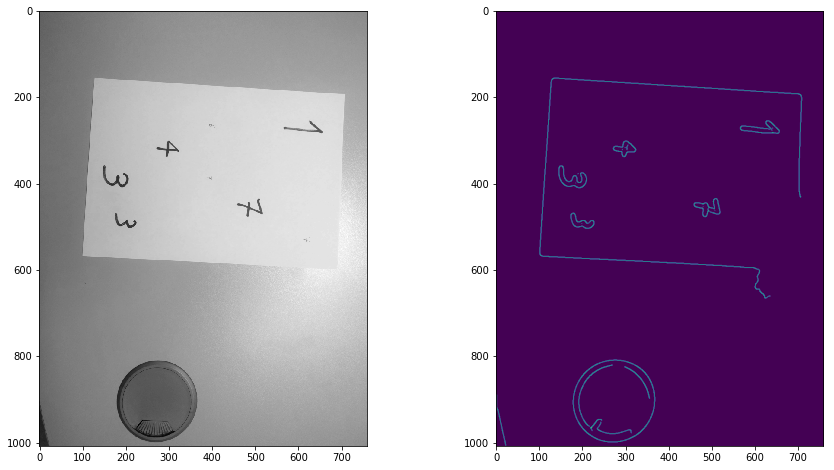

In [5]:
fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
image = images[20]
ax0.imshow(image, cmap="gray")
ax1.imshow(calc_edges(image), interpolation='bilinear')

# Preprocessing for a single image

Here I explain my way of finding the digits on the sheet of paper. The resulting method is called find_regions()

**Ugliness**: I don't correct for the actual orientation of the paper. In the end, I cut out a region of the image and scale it to width and height of a Vertical A4 paper. This may introduce stretching and shortening of the axes.

## Problems
Overall it is a construct of hopes and dreams. The hope is that the input image always contains such a low noise level, while the dream is that the probabilistic_hough_line always finds a line for each edge of the paper. 

Hough lines is the heart and soul in this step. If it does not detect all edges of the paper sheet, this part fails. If a background edge is located early in the array of hough lines, this part likely fails.

In [10]:
def get_angle(l0, l1):
    dot = np.dot(l0, l1)
    return np.arccos(dot/(lin.norm(l0)* lin.norm(l1)))

def get_intersection(l0, l1):
    lab = np.cross(l0[0], l0[1])
    lcd = np.cross(l1[0], l1[1])
    i = np.cross(lab, lcd)
    i = i / i[2]
    return i[0:2]


def get_adjacent(line, opline,  llines):
    lab = np.cross(llines[line,0], llines[line,1])
    lxy = np.cross(llines[opline, 0], llines[opline, 1])
    
    for i in range(0, llines.shape[0]):
        if not i == line and not i == opline:
            lcd = np.cross(llines[i, 0], llines[i,1])
            angle_ac = np.abs(np.degrees(get_angle(lab[0:2], lcd[0:2])))
            angle_xc = np.abs(np.degrees(get_angle(lxy[0:2], lcd[0:2])))
            if angle_ac > 25 and angle_xc > 25:
                return i

def get_opposite(line, llines):
    lab = np.cross(llines[line, 0], llines[line, 1])
    for i in range(0, llines.shape[0]):
        if not i == line:
            lac = np.cross(llines[line, 0], llines[i,0])
            lcd = np.cross(llines[i, 0], llines[i,1])
            distance = np.abs(lin.norm(np.cross(lab, lac)) / lin.norm(lab))
            angle = get_angle(lab[0:2], lcd[0:2])
            angle = np.abs(np.degrees(angle))

            #if angle is smaller than 25 degrees and distance larger than 50 pixels, we found the opposite
            if angle < 30 and distance > 50:
                return i
            
def flip_to_lower_left(i, j, dim, sorted_lines):
    minI = min(sorted_lines[i, :, dim])
    minJ = min(sorted_lines[j, :, dim])
    if minI > minJ:
        tmp = sorted_lines[i].copy()
        sorted_lines[i] = sorted_lines[j]
        sorted_lines[j] = tmp
    return sorted_lines

def find_regions(image):
    edges = calc_edges(image)
    lines = transform.probabilistic_hough_line(edges, threshold=100, line_length=150, line_gap=100)
    
    llines = np.ones((len(lines),2,3))
    llines[:, :, 0:2] = np.asarray(lines)

    sorted_lines = np.ones((4,2,3))
    sorted_lines[0] = llines[0]
    op = get_opposite(0, llines)
    sorted_lines[2] = llines[op]
    adjacent = get_adjacent(0, op, llines)
    sorted_lines[1] = llines[adjacent]
    adjacent_op = get_opposite(adjacent, llines)
    sorted_lines[3]= llines[adjacent_op]
    sorted_lines = flip_to_lower_left(0, 2, 0, sorted_lines)
    sorted_lines = flip_to_lower_left(0, 2, 1, sorted_lines)
    sorted_lines = flip_to_lower_left(3, 1, 0, sorted_lines)
    sorted_lines = flip_to_lower_left(3, 1, 1, sorted_lines)

    intersections = np.zeros((4, 2))
    intersections[0] = get_intersection(sorted_lines[0],sorted_lines[1])
    intersections[1] = get_intersection(sorted_lines[1],sorted_lines[2])
    intersections[2] = get_intersection(sorted_lines[2],sorted_lines[3])
    intersections[3] = get_intersection(sorted_lines[3],sorted_lines[0])
    rounded = np.round(intersections)
    
    w,h = 900, round(900*1.404)
    A = np.array([0,h])
    B = np.array([w,h])
    C = np.array([w,0])
    D = np.array([0,0])
    tf = transform.estimate_transform("projective",
                                      src = rounded,
                                      dst=np.vstack((A,B,C,D)))
    page = skimage.transform.warp(image=image, inverse_map=tf.inverse, output_shape=(h,w))
    
    page = skimage.img_as_float(page)
    binary = page < filters.threshold_local(page, 51, mode='reflect', offset=0.05)
    binary = morphology.erosion(morphology.erosion(morphology.dilation(morphology.dilation(binary))))
    labels = skimage.measure.label(binary)
    rp = skimage.measure.regionprops(labels)
    regions = [r for r in rp if r.area > 80 and r.bbox[2] - r.bbox[0] > 10 and  r.bbox[3] - r.bbox[1] > 10 ]
    return regions

### find edges of the paper 

I assume that we find at least one line segment per side.

Plus, I assume background lines come late in the array

In [40]:
image = images[16]
edges = calc_edges(image)
lines = transform.probabilistic_hough_line(edges, threshold=100, line_length=150, line_gap=100)

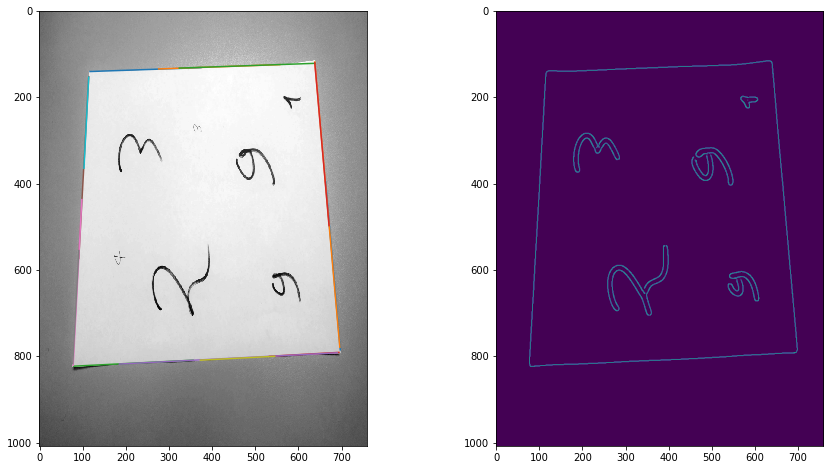

In [41]:
fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
ax0.imshow(image, cmap="gray")
ax1.imshow(edges, interpolation='bilinear')
for ((x0,y0),(x1,y1)) in lines:
    ax0.plot([x0,x1],[y0,y1])

### Adjacent and Opposite lines

Now I loot for adjacent and opposite lines. I first assume that lines[0] is an edge of the paper. I then look for the opposite line to lines[0]. The opposite line has a similar angle to lines[0], but is several pixels away. I assume > 50 pixels.

Side note: Since the lines can be in any order, I sort them so the intersections are sorted counter-clockwise.

In [42]:
llines = np.ones((len(lines),2,3))
llines[:, :, 0:2] = np.asarray(lines)

sorted_lines = np.ones((4,2,3))
sorted_lines[0] = llines[0]
op = get_opposite(0, llines)
sorted_lines[2] = llines[op]
adjacent = get_adjacent(0, op, llines)
sorted_lines[1] = llines[adjacent]
adjacent_op = get_opposite(adjacent, llines)
sorted_lines[3]= llines[adjacent_op]
sorted_lines = flip_to_lower_left(0, 2, 0, sorted_lines)
sorted_lines = flip_to_lower_left(0, 2, 1, sorted_lines)
sorted_lines = flip_to_lower_left(3, 1, 0, sorted_lines)
sorted_lines = flip_to_lower_left(3, 1, 1, sorted_lines)

intersections = np.zeros((4, 2))
intersections[0] = get_intersection(sorted_lines[0],sorted_lines[1])
intersections[1] = get_intersection(sorted_lines[1],sorted_lines[2])
intersections[2] = get_intersection(sorted_lines[2],sorted_lines[3])
intersections[3] = get_intersection(sorted_lines[3],sorted_lines[0])
rounded = np.round(intersections)
print(rounded)

[[ 77. 823.]
 [698. 792.]
 [639. 122.]
 [115. 140.]]


### Paper sheet

Now we have the intersections of the paper sheet, and cut it out. Next, we use an adaptive thresholding to find the digits on the sheet.

Regions are filtered according to size. The area should be larger than 80 pixels and the bounding box over 10 pixels in each axis.

With the adaptive thresholding, the algorithm sometimes locates strips of pixels along the border of the paper. I played around with the border-case algorithm, but could not get rid of them quickly. I introduced the additional bounding box requirement, and it seems to work alright.

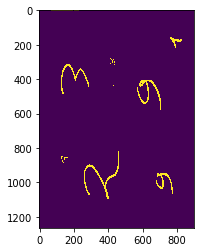

In [43]:
w,h = 900, round(900*1.404)
A = np.array([0,h])
B = np.array([w,h])
C = np.array([w,0])
D = np.array([0,0])

tf = transform.estimate_transform("projective",
                                  src = rounded,
                                  dst=np.vstack((A,B,C,D)))
page = skimage.transform.warp(image=image, inverse_map=tf.inverse, output_shape=(h,w))
page = skimage.img_as_float(page)
binary = page < filters.threshold_local(page, 51, mode='reflect', offset=0.01)
binary = morphology.erosion(morphology.erosion(morphology.dilation(morphology.dilation(binary))))
plt.imshow(binary)

In [14]:
labels = skimage.measure.label(binary)
rp = skimage.measure.regionprops(labels)
regions = [r for r in rp if r.area > 80 and r.bbox[2] - r.bbox[0] > 10 and  r.bbox[3] - r.bbox[1] > 10 ]
print(len(regions))

11


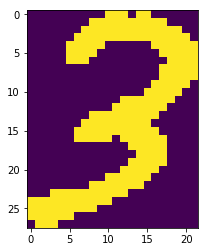

In [15]:
plt.imshow(regions[9].image)

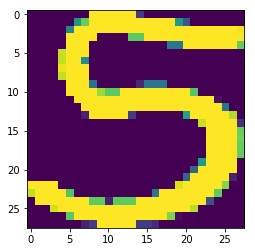

In [20]:
plt.imshow(transform.resize(regions[5].image, (img_rows, img_cols), anti_aliasing=False))

# MNIST Training

I copied the CNN from the Keras example guide, but expanded the train- and test- sets with rotated digits. This increases the dataset by a factor of 4.

Because do not guarantee an orientation in the region detection, a digit may be rotated by 90, 180 or 270 degrees. I let the CNN handle this issue and try to detect rotated digits as well.

In [21]:
# add rotated input
(x_train, y_train), (x_test, y_test) = mnist.load_data()
xr1 = np.rot90(x_train, axes=(1,2))
xtr1 = np.rot90(x_test, axes=(1,2))
xr2 = np.rot90(xr1, axes=(1,2))
xtr2 = np.rot90(xtr1, axes=(1,2))
xr3 = np.rot90(xr2, axes=(1,2))
xtr3 = np.rot90(xtr2, axes=(1,2))

x_train_full = np.vstack((x_train, xr1, xr2, xr3))
y_train_full = np.concatenate((y_train, y_train, y_train, y_train))

x_test_full = np.vstack((x_test, xtr1, xtr2, xtr3))
y_test_full = np.concatenate((y_test, y_test,y_test,y_test))

In [22]:
if K.image_data_format() == 'channels_first':
    x_train = x_train_full.reshape(x_train_full.shape[0], 1, img_rows, img_cols)
    x_test = x_test_full.reshape(x_test_full.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train_full.reshape(x_train_full.shape[0], img_rows, img_cols, 1)
    x_test = x_test_full.reshape(x_test_full.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train_full, num_classes)
y_test = keras.utils.to_categorical(y_test_full, num_classes)

x_train shape: (240000, 28, 28, 1)
240000 train samples
40000 test samples


In [1133]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [1134]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 240000 samples, validate on 40000 samples
Epoch 1/12
240000/240000 [==============================] - 1000s 4ms/step - loss: 0.3721 - acc: 0.8828 - val_loss: 0.1100 - val_acc: 0.9665
Epoch 2/12
240000/240000 [==============================] - 1023s 4ms/step - loss: 0.1810 - acc: 0.9458 - val_loss: 0.0876 - val_acc: 0.9726
Epoch 3/12
240000/240000 [==============================] - 909s 4ms/step - loss: 0.1552 - acc: 0.9540 - val_loss: 0.0771 - val_acc: 0.9763
Epoch 4/12
240000/240000 [==============================] - 970s 4ms/step - loss: 0.1411 - acc: 0.9591 - val_loss: 0.0745 - val_acc: 0.9778
Epoch 5/12
240000/240000 [==============================] - 974s 4ms/step - loss: 0.1332 - acc: 0.9613 - val_loss: 0.0740 - val_acc: 0.9792
Epoch 6/12
240000/240000 [==============================] - 1016s 4ms/step - loss: 0.1274 - acc: 0.9636 - val_loss: 0.0640 - val_acc: 0.9805
Epoch 7/12
240000/240000 [==============================] 

In [1136]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.06089289667453777
Test accuracy: 0.9822


In [1135]:
model.save(model_path)

In [ ]:
resizeImg = transform.resize(regions[2].image, (img_rows, img_cols), anti_aliasing=False)
predictions = model.predict(resizeImg.reshape(1,img_rows, img_cols, 1))
print(np.argmax(predictions))

# Full algorithm

Here I put everything together and do some predictions

**7, 3, 1**: The prediction does not work smoothly. I presume this is partially due to the rotated digits, increasing the degrees of freedom. In this case, the algorithm puts out a large number of 7, 3, and 1. This is one of the largest sources of error. Even though the rest of the pipeline "works", the digit detection is not reliable enough. It confuses digits, which a human should be able to reliably detect, even in a rotated state (for example a 4. It is distinct even when it was rotated). I presumed the CNN would be confusing 6 and 9, but instead, it just returns 3 for both.

**wrong aspect ratio** An example of the problem can be seen in images[16]. It is loaded with the wrong aspect ratio, which in turn leads to a heavily warped regions. In this case, the CNN interprets the warped 9 as 3.

**Upscale, downscale** some regions are scaled up, while others are scaled down. For downscaled regions, the thin line drawn inside gets vanishingly small. In this case, I simply set every non-zero pixel in the scaled version to 1.0. This only helps in very few cases, and probably should be removed.


In [23]:
model = keras.models.load_model(model_path) 
for image in images:
    try:
        regions = find_regions(image)
        output = np.zeros(len(regions))
        i = 0
        for r in regions:
            resized = transform.resize(r.image, (img_rows, img_cols), anti_aliasing=False)
            if r.area > img_rows * img_cols:
                resized[resized > 0] = 1.0
            predictions = model.predict(resized.reshape(1,img_rows, img_cols, 1))
            p = np.argmax(predictions)
            output[i] = p
            i += 1

        print("found numbers:", output)
    except:
        print("unable to locate regions")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
unable to locate regions
found numbers: [3. 7. 7. 5. 7. 7. 3. 3.]
found numbers: [7. 3. 7. 3. 3. 5. 7.]
found numbers: [7. 3. 2. 3. 3. 5. 7.]
found numbers: []
found numbers: [8. 1. 3. 7. 2. 2. 7. 3.]
unable to locate regions
found numbers: [1. 3. 3. 7. 3. 5. 5. 7.]
found numbers: [1. 7. 7. 7. 7. 5. 7. 3. 3.]
unable to locate regions
unable to locate regions
found numbers: [7. 7. 8. 5. 1. 7. 1. 5. 2. 7. 3. 3.]
unable to locate regions
found numbers: [1.]
found numbers: [8.]
found numbers: [7. 7. 3. 3. 5. 2. 7. 5. 1.]
found numbers: [7. 3. 3. 3. 7. 7. 2.]
found numbers: []
found numbers: [1. 3. 3. 7. 5. 7. 5. 7. 3.]
found numbers: [1. 1. 5. 2. 2. 5. 7. 3. 3. 1. 3.]
found numbers: [1. 3. 3. 8. 2. 4. 4. 5. 7.]


found numbers: [7. 3. 3. 3. 7. 8. 2.]


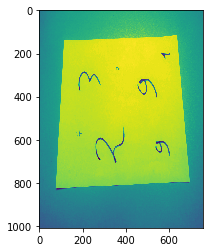

In [44]:
image = images[16]
plt.imshow(image)
regions = find_regions(image)
output = np.zeros(len(regions))

i = 0
for r in regions:
    resized = transform.resize(r.image, (img_rows, img_cols), anti_aliasing=False)
    
    #If the region is scaled down, the digit tends to vanish
    if r.area > img_rows * img_cols:
        resized[resized > 0] = 1
    predictions = model.predict(resized.reshape(1,img_rows, img_cols, 1))
    p = np.argmax(predictions)
    output[i] = p
    i += 1

print("found numbers:", output)

7


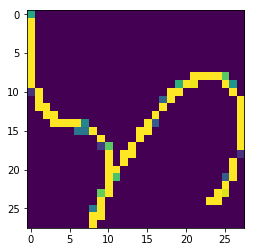

In [45]:
resized = transform.resize(regions[4].image, (img_rows, img_cols), anti_aliasing=False)
predictions = model.predict(resized.reshape(1,img_rows, img_cols, 1))
plt.imshow(resized)
print(np.argmax(predictions))